# Lateral ventricle volume trajectories and response inhibition - feat

2021, Arvid Lundervold

*Astri J. Lundervold, Alexandra Vik, Arvid Lundervold* <br>
**Lateral ventricle volume trajectories predict response inhibition in older age - a
longitudinal brain imaging and machine learning approach** <br>
 (to appear in PLOS ONE)

The linear mixed effect model (LME) was fitted to the data, i.e.

$$\text{Vol}_{ij} = \beta_0 + \beta_1 \text{Age}_{ij} + (b_{0i} + b_{1i} \text{Age}_{ij}) + \epsilon_{ij}$$

Here, $\text{Vol}_{ij}$ the continuous *response variable* in the model is volume of left (right) latreral ventricle in subject $i$ ($i=1,\ldots,N$) at wave $j$ ($j=1,\ldots,n_i$). In our case we have $N=74$ and three wase with complete data, i.e. $n_i=3$ for all $i$. $\text{Age}_{ij}$ is age (in years) of subject $j$ at wave $j$, and a *predictor variable* in the model.

The model parameterrs $\beta_0$ and $\beta_1$ are *fixed effects* parameters.  The variables $b_{0i}$ and $b_{1i}$ 
($i=1,\ldots,N$) are the *random effects* parameters, assumed to be normally distributed witrh zero mean. They denote individual deviations in intercept ($b_{0i}$) and slope ($b_{1i}$), respectiveley, from the group-level fixed effect.
Finally, the random residual errors $\epsilon_{ij}$ are assumed to be independent and normally distributed (i.i.d) with zero mean and constant variance $\sigma_\epsilon^2$.

**Select if eTIV-normalization of lateral ventricle volumes should be used or not**

In [1]:
eTIV_NORMALIZED = False

### Packages and libraries

**`rpy2` should be tested through `0.0-test.ipynb`**

In [2]:
import os
import os.path as op
import sys
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import math
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
from sklearn import tree
#import graphviz
#from distutils.sysconfig import get_python_lib
import sklearn
import matplotlib
#import rpy2
#from rpy2.robjects import r, pandas2ri
#pandas2ri.activate()
#from rpy2.robjects.lib.tidyr import DataFrame

# Enable inline plotting
%matplotlib inline

In [3]:
print('Python version ' + sys.version)
#print(get_python_lib())
print('numpy: %s' % np.__version__)
print('pandas: %s' % pd.__version__)
print('scipy: %s' % scipy.__version__)
print('matplotlib: %s' % matplotlib.__version__)
print('sklearn: %s' % sklearn.__version__)
print('seaborn: %s' % sns.__version__)
#print('graphviz: %s' % graphviz.__version__)
#print('rpy2: %s' % rpy2.__version__)

Python version 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
numpy: 1.19.2
pandas: 1.2.1
scipy: 1.5.2
matplotlib: 3.3.2
sklearn: 0.23.2
seaborn: 0.11.1


## Reading data

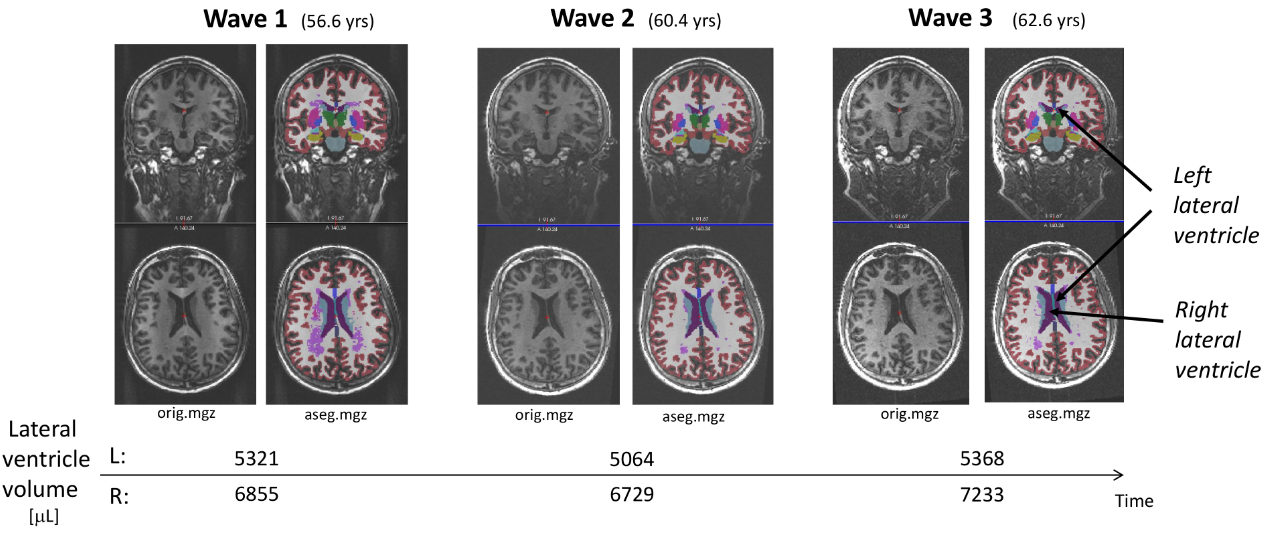

In [4]:
from IPython.display import Image
Image(filename='../assets/Figure1.png', width=800)

In [5]:
fn_data = '../data/01_lvv_ri_renamed_data.csv'
df = pd.read_csv(fn_data)
df.head()

subj gender   yrW1   yrW2   yrW3  left_lvvW1  left_lvvW2  left_lvvW3  \
0  subj_01      F  56.63  60.35  62.62      5321.4      5063.6      5368.3   
1  subj_02      M  49.07  52.58  55.05     11038.6     11912.2     12313.3   
2  subj_03      M  74.61  78.14  80.59     29718.4     32265.1     35887.0   
3  subj_04      M  56.23  59.78  62.68     21830.1     23933.6     26164.2   
4  subj_05      M  63.22  67.00  69.53     17205.1     16970.1     15858.1   

   right_lvvW1  right_lvvW2  right_lvvW3          eTIV    RI  
0       6855.2       6729.2       7233.2  1.232679e+06  66.0  
1      10611.6      11774.8      12070.5  1.464692e+06  85.0  
2      34241.0      37155.2      41221.4  1.385841e+06  71.0  
3      15243.9      16505.1      18509.1  1.529445e+06  41.0  
4      13962.1      13755.5      13143.9  1.371460e+06  62.0

In [6]:
df['id'] = df['subj'].astype(str).str[-2:].astype(np.int)
df.head()

subj gender   yrW1   yrW2   yrW3  left_lvvW1  left_lvvW2  left_lvvW3  \
0  subj_01      F  56.63  60.35  62.62      5321.4      5063.6      5368.3   
1  subj_02      M  49.07  52.58  55.05     11038.6     11912.2     12313.3   
2  subj_03      M  74.61  78.14  80.59     29718.4     32265.1     35887.0   
3  subj_04      M  56.23  59.78  62.68     21830.1     23933.6     26164.2   
4  subj_05      M  63.22  67.00  69.53     17205.1     16970.1     15858.1   

   right_lvvW1  right_lvvW2  right_lvvW3          eTIV    RI  id  
0       6855.2       6729.2       7233.2  1.232679e+06  66.0   1  
1      10611.6      11774.8      12070.5  1.464692e+06  85.0   2  
2      34241.0      37155.2      41221.4  1.385841e+06  71.0   3  
3      15243.9      16505.1      18509.1  1.529445e+06  41.0   4  
4      13962.1      13755.5      13143.9  1.371460e+06  62.0   5

## Model-based (lmer) feature design

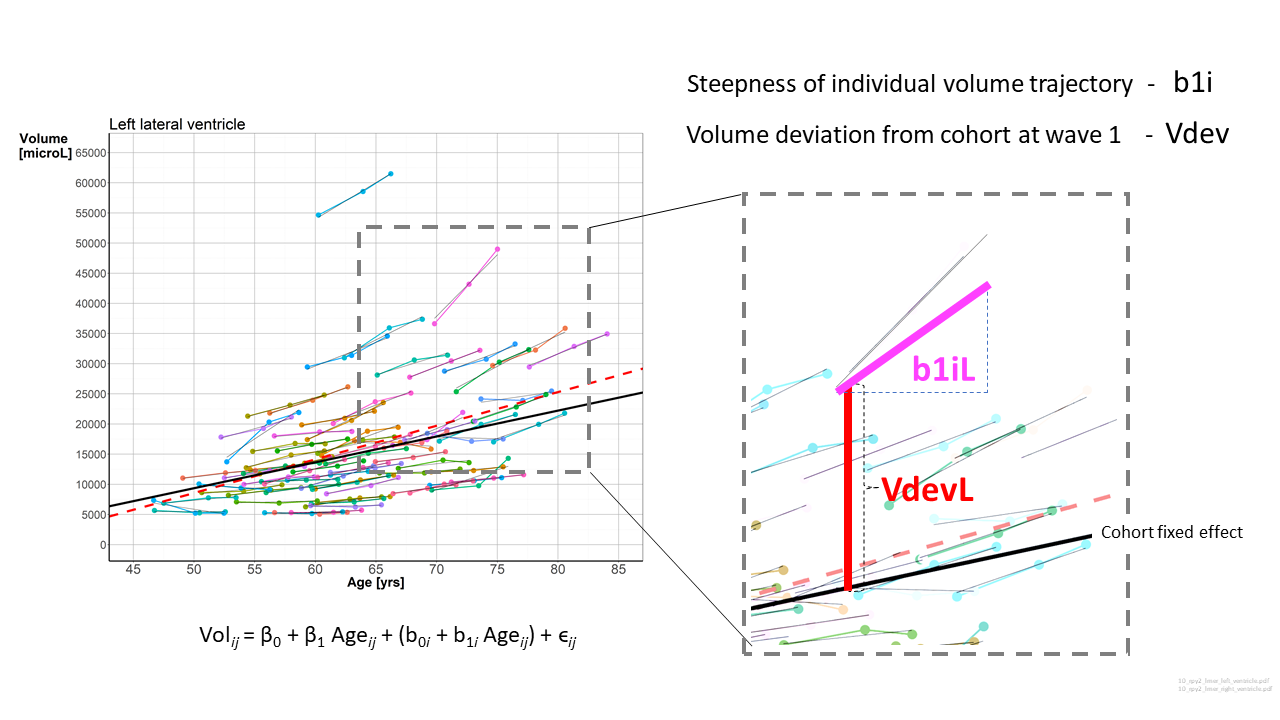

In [7]:
Image('../assets/Fig_2_LME_derived_features.png', width=900)

**Read and explore the features**

In [8]:
# Read the lmer feature data to the present repository as .csv
if eTIV_NORMALIZED:
    dfmri = pd. read_csv('../results/02_lvv_ri_new_R_lmer_feature_data_eTIV_norm.csv')
else:
    dfmri = pd. read_csv('../results/02_lvv_ri_new_R_lmer_feature_data.csv')   

In [9]:
dfmri['id'] =  df['id'].values
mydf = dfmri.copy()
mydf.head()

Gender   Age3        b1iL        b1iR        VdevL         VdevR  RI3  id
0      F  62.62 -403.106006 -255.837480 -7043.921304  -5184.324848   66   1
1      M  55.05 -192.279528   18.445213  2022.833808   1484.915004   85   2
2      M  80.59  504.164116  431.948484  9742.140838  15864.793556   71   3
3      M  62.68  242.654739  143.700117  9671.260622   3369.298064   41   4
4      M  69.53 -535.067249 -119.315203  1969.929309  -1779.977513   62   5

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
mydf.head()

Gender   Age3        b1iL        b1iR        VdevL         VdevR  RI3  id
0      F  62.62 -403.106006 -255.837480 -7043.921304  -5184.324848   66   1
1      M  55.05 -192.279528   18.445213  2022.833808   1484.915004   85   2
2      M  80.59  504.164116  431.948484  9742.140838  15864.793556   71   3
3      M  62.68  242.654739  143.700117  9671.260622   3369.298064   41   4
4      M  69.53 -535.067249 -119.315203  1969.929309  -1779.977513   62   5

In [12]:
mydfx = mydf.drop(['Gender', 'id'], axis=1)
mydfx.head()

Age3        b1iL        b1iR        VdevL         VdevR  RI3
0  62.62 -403.106006 -255.837480 -7043.921304  -5184.324848   66
1  55.05 -192.279528   18.445213  2022.833808   1484.915004   85
2  80.59  504.164116  431.948484  9742.140838  15864.793556   71
3  62.68  242.654739  143.700117  9671.260622   3369.298064   41
4  69.53 -535.067249 -119.315203  1969.929309  -1779.977513   62

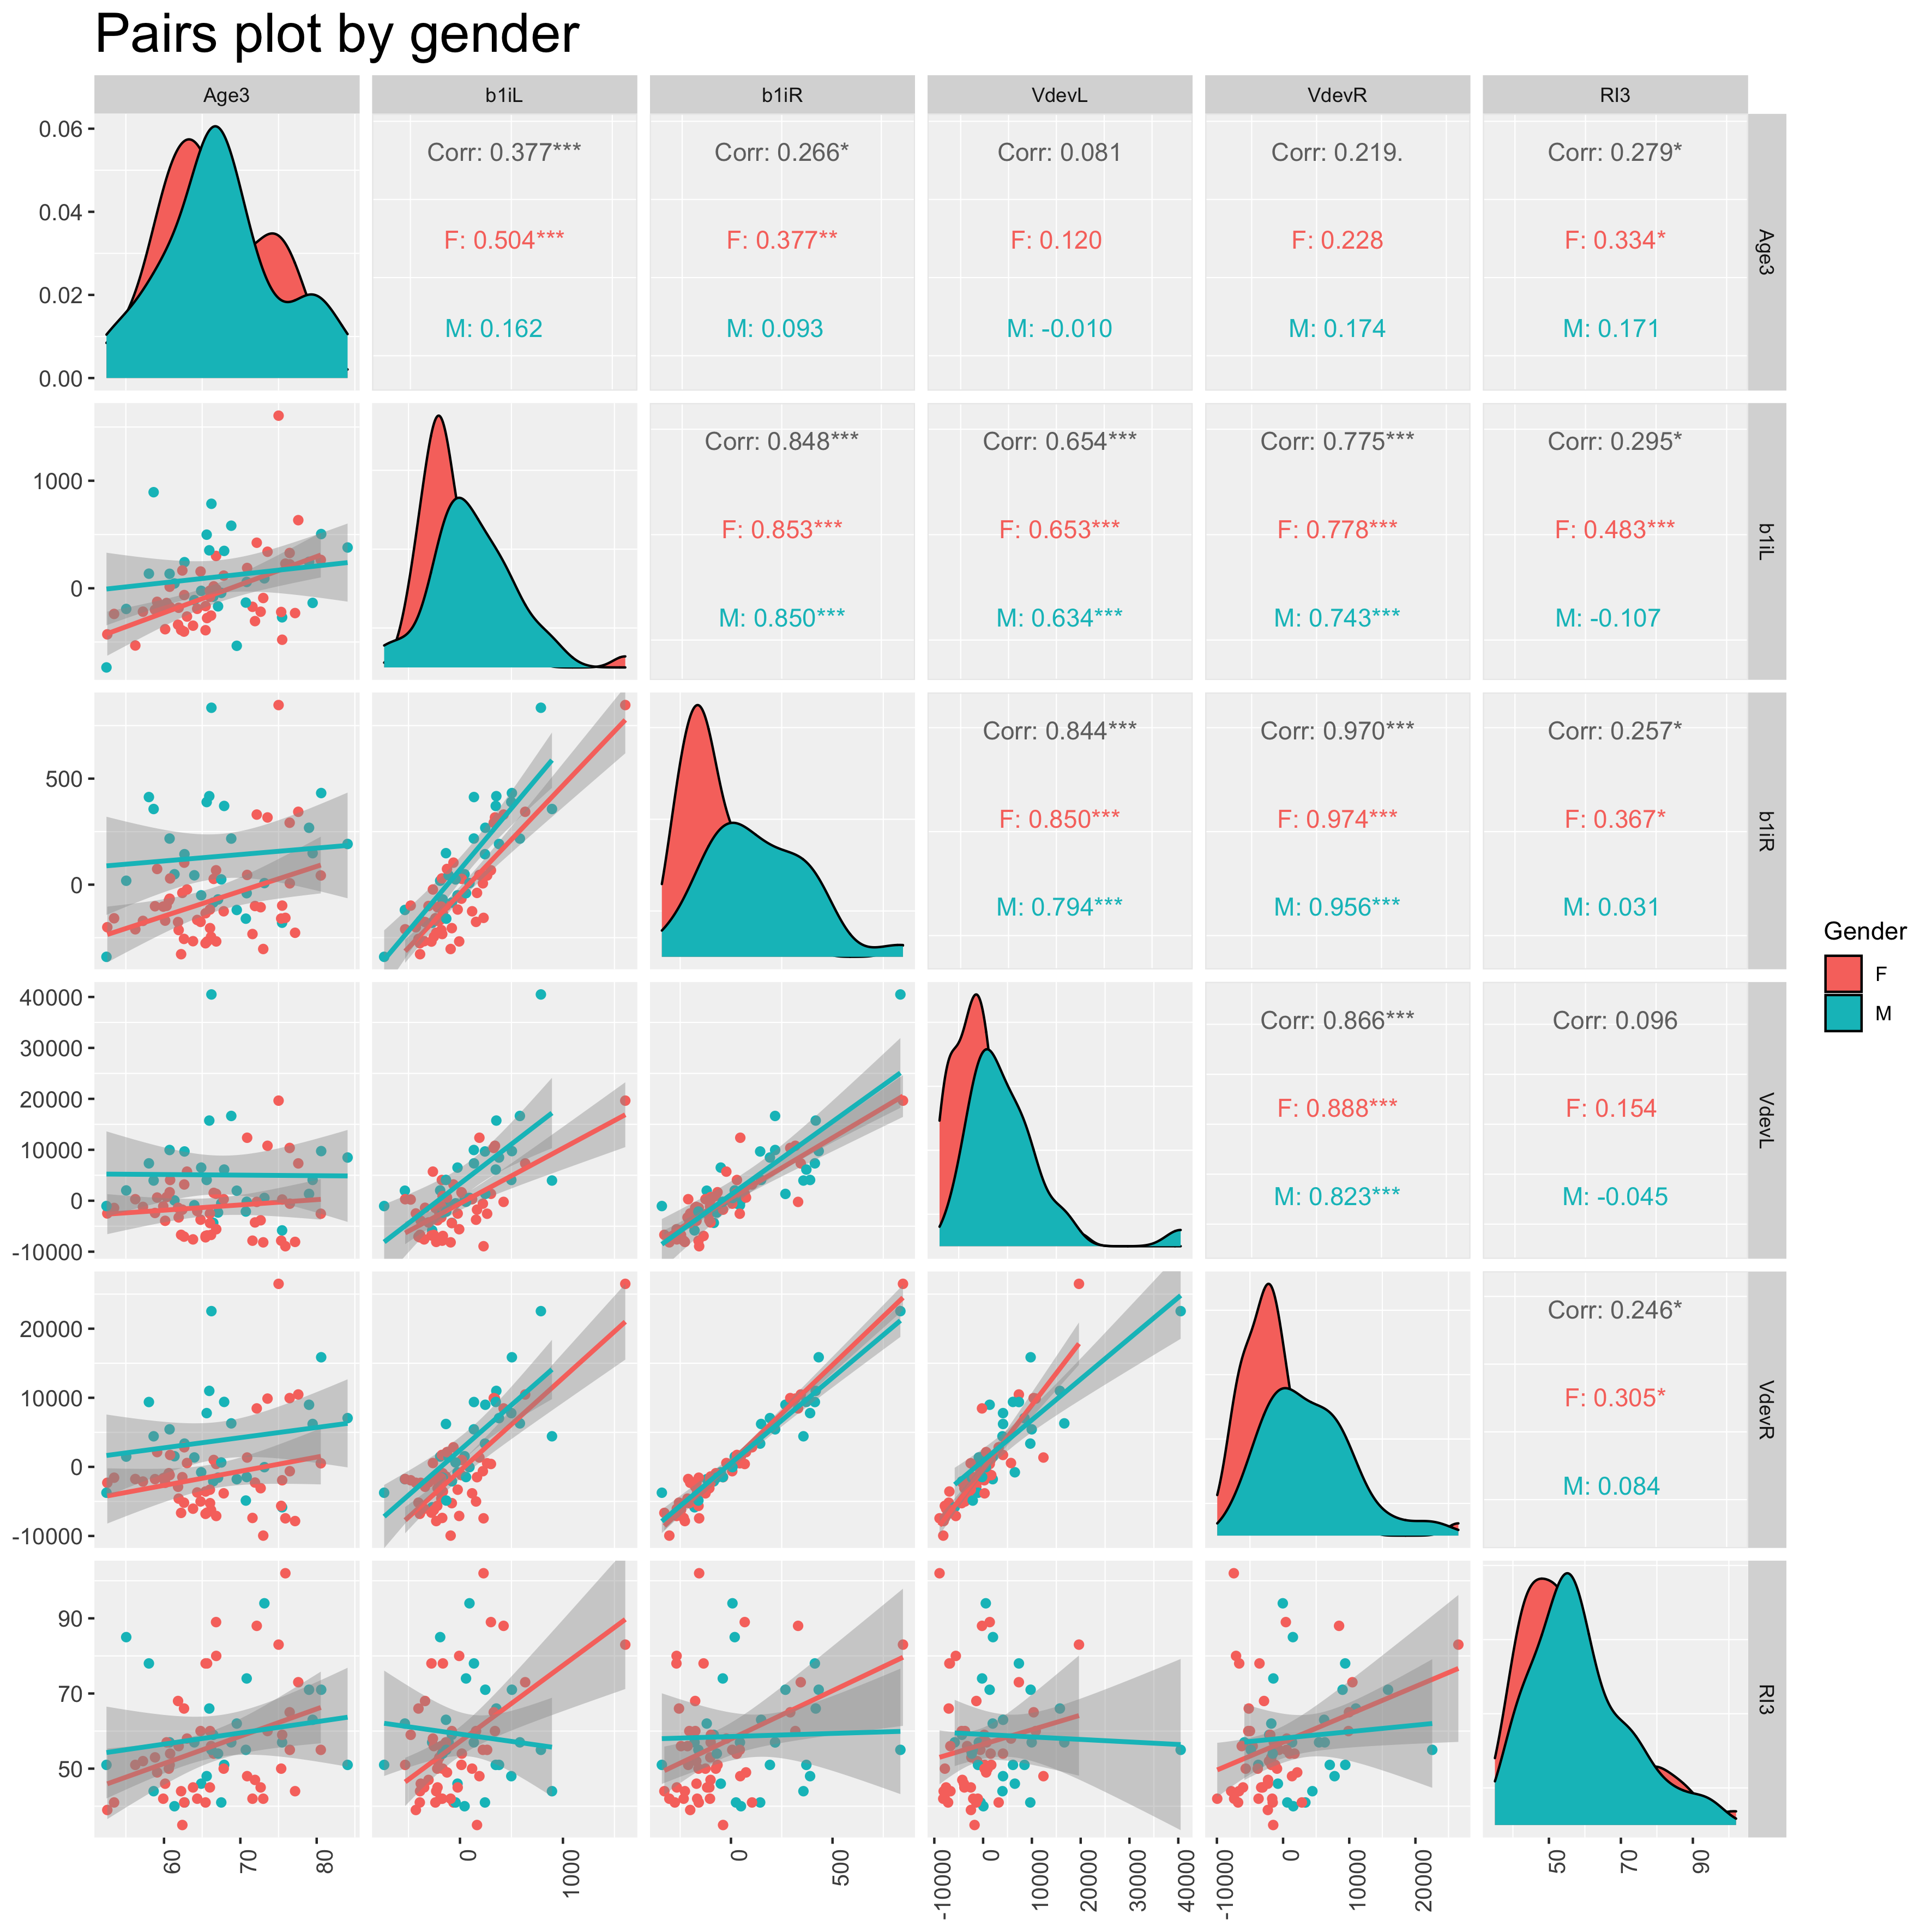

In [13]:
Image('./figs/03_lvv_ri_new_R_ggplot_ggpairs_lmer_vdev_by_gender.png')

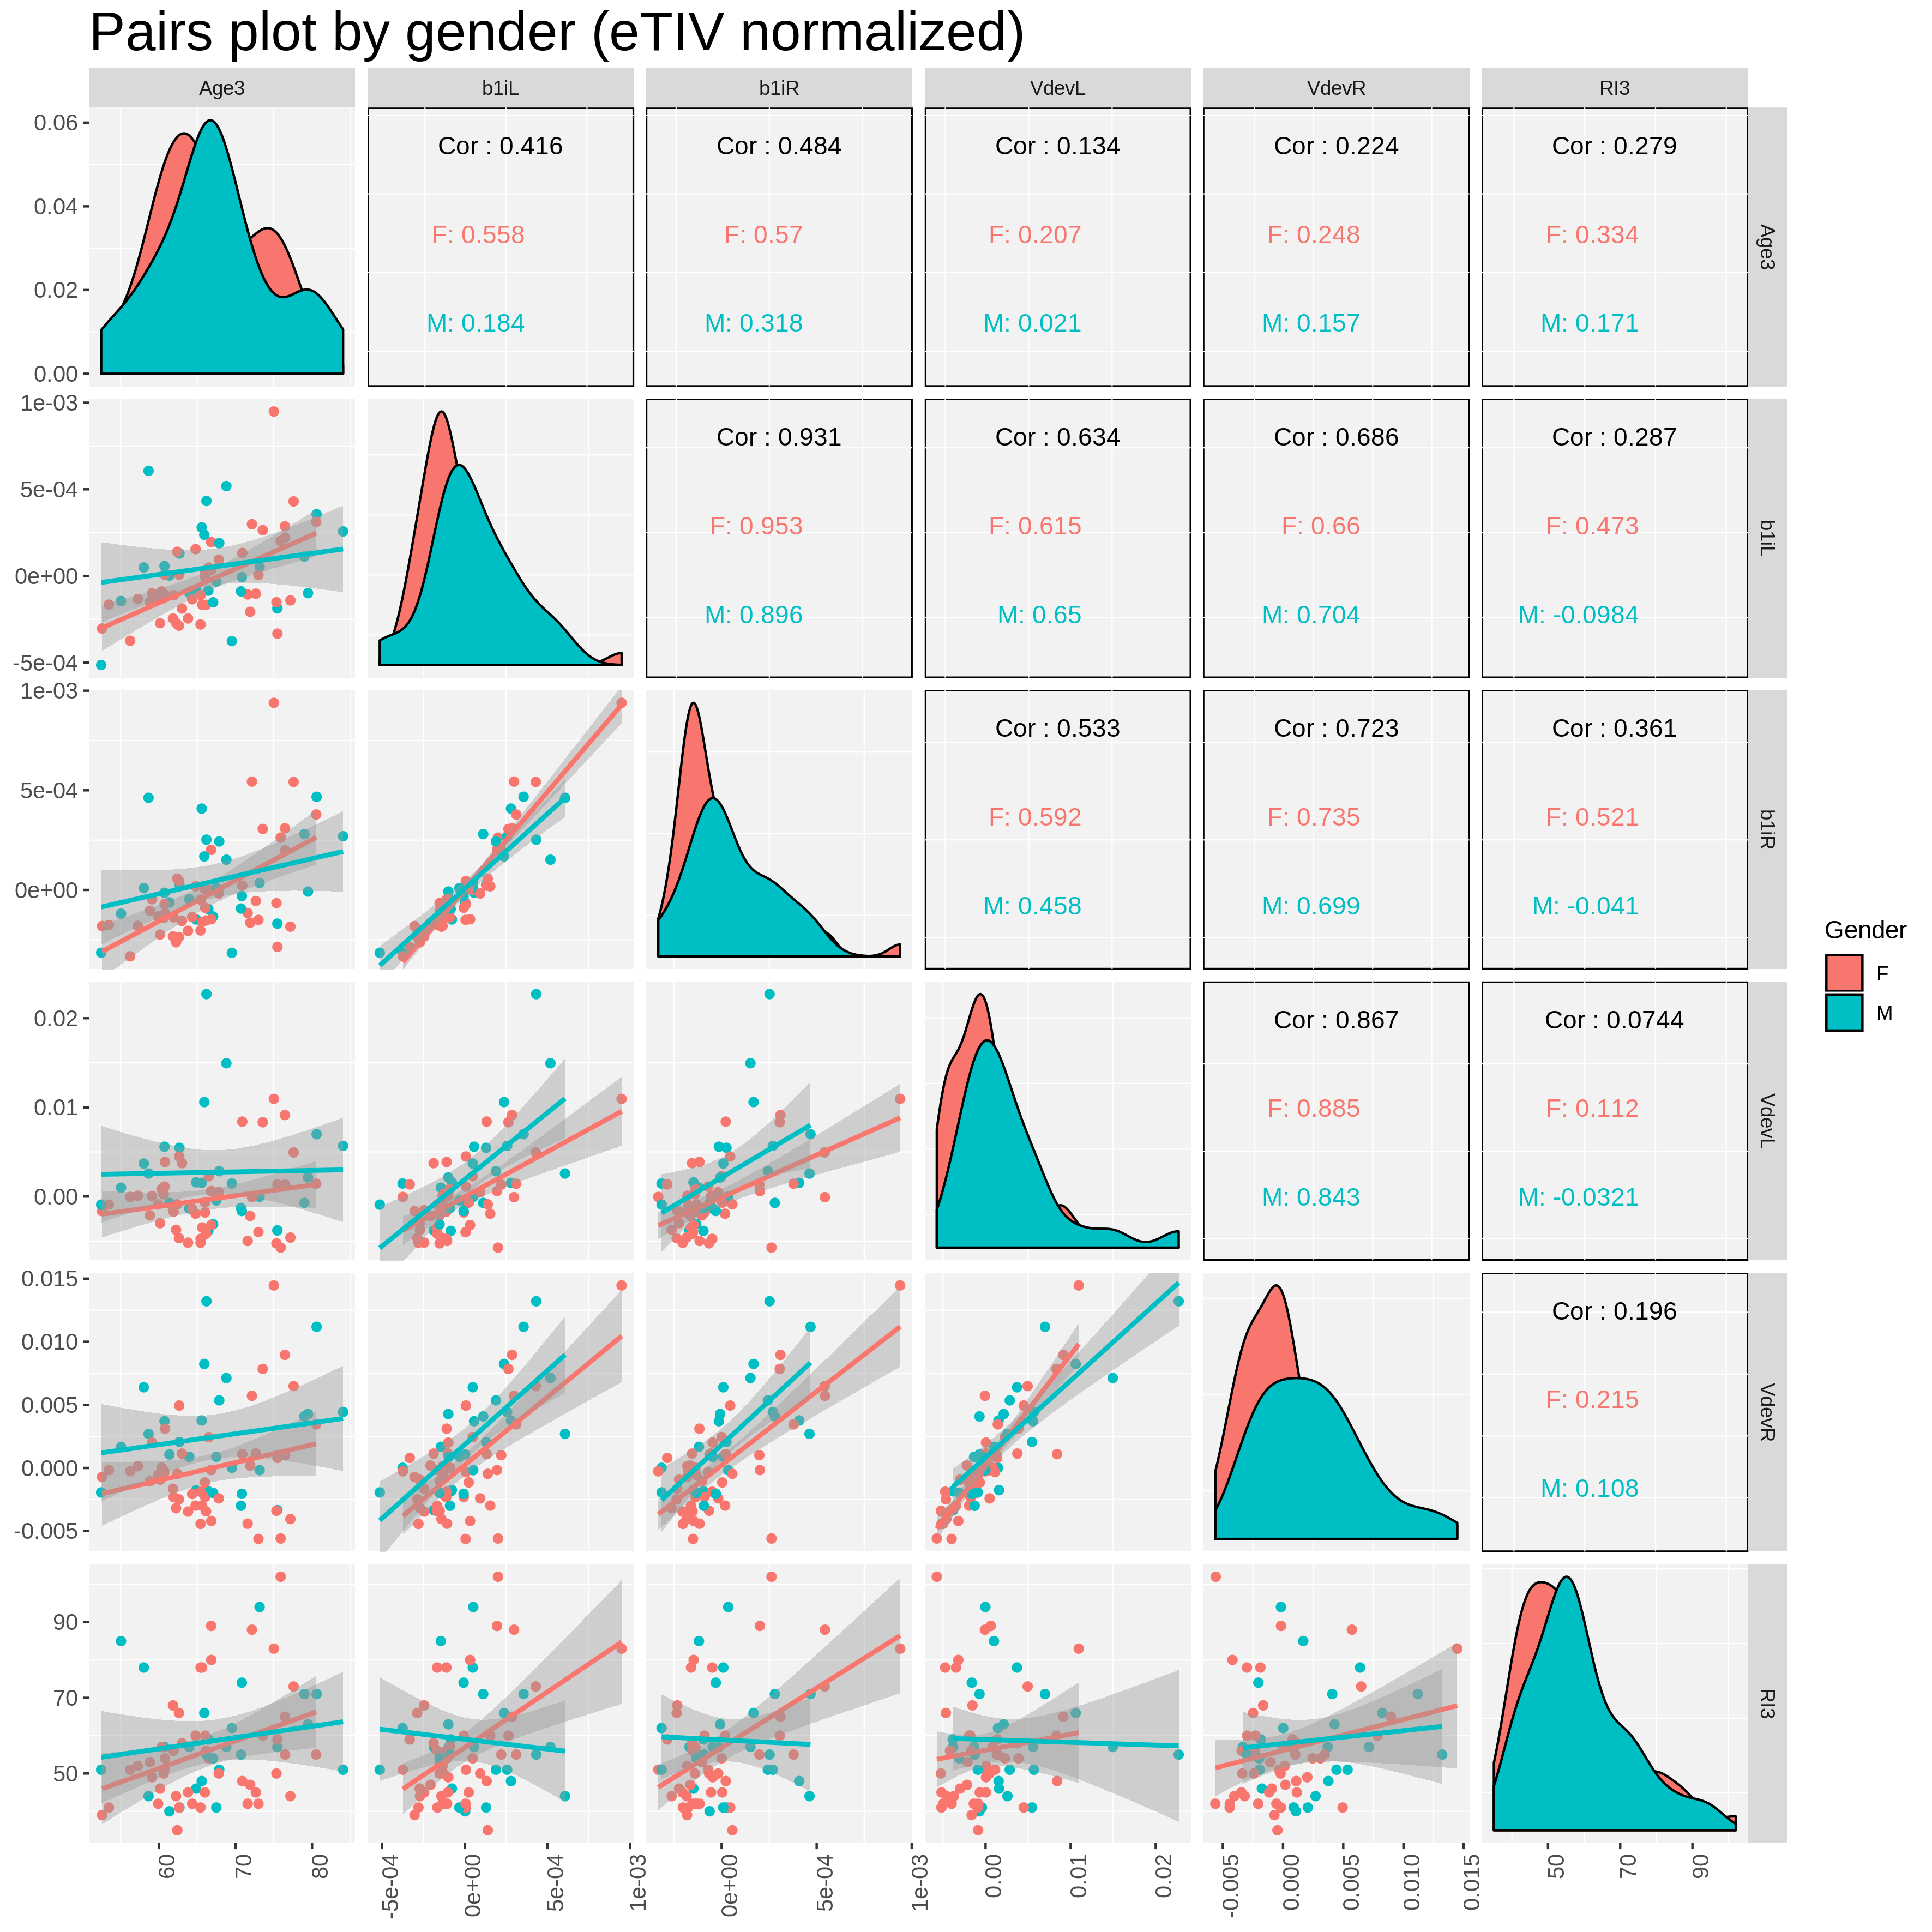

In [14]:
# Needs a run initialized with
# eTIV_NORMALIZED = True

Image('../figures/03_lvv_ri_rpy2_ggplot_ggpairs_lmer_vdev_by_gender_eTIV_norm.png')

## Discretization of outcome variable (RI3  and RI3resid)

```python
pandas.qcut(x, q, labels=None, retbins=False, precision=3, duplicates='raise')
```
Quantile-based discretization function. Discretize variable into equal-sized buckets based on rank or based on sample quantiles. For example 1000 values for 10 quantiles would produce a Categorical object indicating quantile membership for each data point.

### 'RI3r'

In [15]:
behavior = 'RI3'

Since several data points might have the same Stroop3 (RI3) value, i.e.

In [16]:
print('Total observations:', dfmri[behavior].size, ' Unique:', dfmri[behavior].unique().size)

Total observations: 74  Unique: 38


we first jitter (add some i.i.d. noise) to obtain unique values:

In [17]:
# Seed the randomness of numpy.random and be able to reproduce it
# https://stackoverflow.com/questions/22994423/difference-between-np-random-seed-and-np-random-randomstate
np.random.seed(42)

behaviorjitter = '%s_jitter' % (behavior)
pure = dfmri[behavior]
noise = np.random.normal(0, 0.05, pure.shape)
if behavior == 'RI3':
    signal = pure + noise
else:
    signal = pure   
dfmri[behaviorjitter] = signal
pd.concat([dfmri[behavior], dfmri[behaviorjitter]], axis=1).head(5).round(3)

RI3  RI3_jitter
0   66      66.025
1   85      84.993
2   71      71.032
3   41      41.076
4   62      61.988

In [18]:
# Check uniqueness of (jittered) RI3
print('Total observations:', dfmri[behaviorjitter].size, ' Unique:', dfmri[behaviorjitter].unique().size)

Total observations: 74  Unique: 74


In [19]:
# Make quintile cuts according to the jittered variable
behaviorcat = '%s_cat' % (behavior)
behaviorlabel = '%s_label' % (behavior)
pd.qcut(dfmri[behaviorjitter], 3).head(5)

0                (58.648, 101.97]
1                (58.648, 101.97]
2                (58.648, 101.97]
3    (34.967000000000006, 49.982]
4                (58.648, 101.97]
Name: RI3_jitter, dtype: category
Categories (3, interval[float64]): [(34.967000000000006, 49.982] < (49.982, 58.648] < (58.648, 101.97]]

In [20]:
pd.qcut(dfmri[behavior], 3).value_counts()

(34.999, 50.0]     27
(58.667, 102.0]    25
(50.0, 58.667]     22
Name: RI3, dtype: int64

In [21]:
# Better is (not unbalanced classes):
pd.qcut(dfmri[behaviorjitter], 3).value_counts()

(34.967000000000006, 49.982]    25
(58.648, 101.97]                25
(49.982, 58.648]                24
Name: RI3_jitter, dtype: int64

In [22]:
# Perform and label the discretization of the original variable, introducing a new *_cat variable
discr, returnbins = pd.qcut(dfmri[behavior], 3, labels=["fast","medium","slow"], retbins=True, precision=3, duplicates='raise') #'drop' )
print('returnbins:', returnbins)
_df = pd.DataFrame([dfmri[behavior], discr]).T
_df.columns = [behavior, behaviorcat]
dfmri[behaviorcat] = _df[behaviorcat]
dfmri[behaviorcat].value_counts()

returnbins: [ 35.          50.          58.66666667 102.        ]


fast      27
slow      25
medium    22
Name: RI3_cat, dtype: int64

In [23]:
# Better is (if unbalanced clases):
# Perform and label the discretization on the jittered variable, introducing a new *_label variable

discr, returnbins = pd.qcut(dfmri[behaviorjitter], 3, labels=["fast","medium","slow"], retbins=True, precision=3, duplicates='raise') #'drop' )
returnbins[0] = min([min(dfmri[behavior]), min(dfmri[behaviorjitter])]) - 0.001*min(dfmri[behavior])  # To secure proper lower interval
returnbins[-1] = max([max(dfmri[behavior]), max(dfmri[behaviorjitter])]) + 0.001*min(dfmri[behavior]) # To secure proper upper interval
returnbins_jitter = returnbins
print('returnbins:', returnbins)
_df = pd.DataFrame([dfmri[behavior], discr]).T
_df.columns = [behavior, behaviorlabel]
dfmri[behaviorlabel] = _df[behaviorlabel]
dfmri[behaviorlabel].value_counts()

returnbins: [ 34.93274401  49.98203246  58.64812509 102.035     ]


slow      25
fast      25
medium    24
Name: RI3_label, dtype: int64

In [24]:
vals, counts = np.unique(dfmri[behaviorlabel], return_counts=True)
print('Category counts (%s): %s %s' % (behaviorlabel, vals, counts))  # as good as it gets

Category counts (RI3_label): ['fast' 'medium' 'slow'] [25 24 25]


**Get the labels of *dfmri[behvarjitter]* usinge the bins computed by the jittered variable**

In [25]:
inds = np.digitize(dfmri[behaviorjitter], bins=returnbins, right=True)
inds.view()

array([3, 3, 3, 1, 3, 3, 1, 2, 1, 2, 3, 2, 1, 2, 2, 2, 2, 3, 2, 2, 1, 1,
       1, 1, 2, 3, 3, 1, 2, 2, 3, 3, 3, 3, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2,
       2, 1, 1, 3, 3, 3, 3, 3, 2, 1, 3, 3, 1, 3, 2, 1, 3, 2, 3, 3, 2, 1,
       1, 1, 2, 1, 1, 1, 2, 3])

In [26]:
dfmri.columns

Index(['Gender', 'Age3', 'b1iL', 'b1iR', 'VdevL', 'VdevR', 'RI3', 'id',
       'RI3_jitter', 'RI3_cat', 'RI3_label'],
      dtype='object')

In [27]:
x = dfmri[behavior]
xj = dfmri[behaviorjitter]
for n in range(x.size):
    print(n, dfmri[behaviorlabel].values[n], returnbins[inds[n]-1].round(3), "<=", x[n], '(jitter:', xj[n].round(3), ')', "<", returnbins[inds[n]].round(3), '  ', inds[n], dfmri['Gender'][n])

0 slow 58.648 <= 66 (jitter: 66.025 ) < 102.035    3 F
1 slow 58.648 <= 85 (jitter: 84.993 ) < 102.035    3 M
2 slow 58.648 <= 71 (jitter: 71.032 ) < 102.035    3 M
3 fast 34.933 <= 41 (jitter: 41.076 ) < 49.982    1 M
4 slow 58.648 <= 62 (jitter: 61.988 ) < 102.035    3 M
5 slow 58.648 <= 89 (jitter: 88.988 ) < 102.035    3 F
6 fast 34.933 <= 46 (jitter: 46.079 ) < 49.982    1 M
7 medium 49.982 <= 57 (jitter: 57.038 ) < 58.648    2 M
8 fast 34.933 <= 48 (jitter: 47.977 ) < 49.982    1 M
9 medium 49.982 <= 50 (jitter: 50.027 ) < 58.648    2 F
10 slow 58.648 <= 59 (jitter: 58.977 ) < 102.035    3 M
11 medium 49.982 <= 56 (jitter: 55.977 ) < 58.648    2 F
12 fast 34.933 <= 40 (jitter: 40.012 ) < 49.982    1 M
13 medium 49.982 <= 51 (jitter: 50.904 ) < 58.648    2 F
14 medium 49.982 <= 57 (jitter: 56.914 ) < 58.648    2 M
15 medium 49.982 <= 54 (jitter: 53.972 ) < 58.648    2 F
16 medium 49.982 <= 52 (jitter: 51.949 ) < 58.648    2 F
17 slow 58.648 <= 78 (jitter: 78.016 ) < 102.035    3 F

In [28]:
print(returnbins)
# [ 34.965       49.9767523   58.64243771 102.035     ]

[ 34.93274401  49.98203246  58.64812509 102.035     ]


In [29]:
# Crosstab using discretization intervals
pd.crosstab(dfmri[behaviorlabel].values, dfmri['Gender'].values, margins=True)

col_0    F   M  All
row_0              
fast    19   6   25
medium  14  10   24
slow    15  10   25
All     48  26   74

In [30]:
dfmri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      74 non-null     object 
 1   Age3        74 non-null     float64
 2   b1iL        74 non-null     float64
 3   b1iR        74 non-null     float64
 4   VdevL       74 non-null     float64
 5   VdevR       74 non-null     float64
 6   RI3         74 non-null     int64  
 7   id          74 non-null     int64  
 8   RI3_jitter  74 non-null     float64
 9   RI3_cat     74 non-null     object 
 10  RI3_label   74 non-null     object 
dtypes: float64(6), int64(2), object(3)
memory usage: 6.5+ KB


In [31]:
myvars = ['id', 'Gender', 'Age3', 'b1iL', 'b1iR', 'VdevL', 'VdevR', 'RI3', 'RI3_label']
df_label = dfmri[myvars]
df_label.head()  

id Gender   Age3        b1iL        b1iR        VdevL         VdevR  RI3  \
0   1      F  62.62 -403.106006 -255.837480 -7043.921304  -5184.324848   66   
1   2      M  55.05 -192.279528   18.445213  2022.833808   1484.915004   85   
2   3      M  80.59  504.164116  431.948484  9742.140838  15864.793556   71   
3   4      M  62.68  242.654739  143.700117  9671.260622   3369.298064   41   
4   5      M  69.53 -535.067249 -119.315203  1969.929309  -1779.977513   62   

  RI3_label  
0      slow  
1      slow  
2      slow  
3      fast  
4      slow

In [32]:
# Save the lmer feature data to the present repository as .csv
if eTIV_NORMALIZED:
    df_label.to_csv('../results/03_lvv_ri_lmer_feature_data_label_eTIV_norm.csv', header=True, index=False)
else:
    df_label.to_csv('../results/03_lvv_ri_lmer_feature_data_label.csv', header=True, index=False)

### Spaghetti plot in R of LVV trajectories labelled with RI3 ('fast', 'medium', 'slow')

In [33]:
# Read the long formated data to the present repository as .csv
if eTIV_NORMALIZED:
    pd_df_longL = pd.read_csv('../results/02_lvv_ri_left_long_data_eTIV_norm.csv')
    pd_df_longR = pd.read_csv('../results/02_lvv_ri_right_long_data_eTIV_norm.csv')
else:
    pd_df_longL = pd.read_csv('../results/02_lvv_ri_left_long_data.csv')
    pd_df_longR = pd.read_csv('../results/02_lvv_ri_right_long_data.csv')

In [34]:
pd_df_longL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   subj    222 non-null    int64  
 1   Region  222 non-null    object 
 2   Wave    222 non-null    int64  
 3   Age     222 non-null    float64
 4   Volume  222 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 8.8+ KB


In [35]:
pd_df_longL.head()

subj                Region  Wave    Age   Volume
0     1  LeftLateralVentricle     1  56.63   5321.4
1     1  LeftLateralVentricle     2  60.35   5063.6
2     1  LeftLateralVentricle     3  62.62   5368.3
3     2  LeftLateralVentricle     1  49.07  11038.6
4     2  LeftLateralVentricle     2  52.58  11912.2

In [36]:
pd_df_longL.shape

(222, 5)

In [37]:
dfL = pd_df_longL.copy()
dfL['id'] = dfL['subj']
dfL = dfL.drop(['Region', 'subj'], axis=1)
dfL.head(4)

Wave    Age   Volume  id
0     1  56.63   5321.4   1
1     2  60.35   5063.6   1
2     3  62.62   5368.3   1
3     1  49.07  11038.6   2

In [38]:
dfmriL = dfmri.copy()
#dfmriL['id'] = pd_df['id']
dfmriL['id'] = dfmri.index+1
# dfmriL['RI3_label'] = df_cat['RI3_label']

dfmriL['RI3_label'] = df_label['RI3_label']
dfmriL = dfmriL.drop(['Gender','Age3','b1iL','b1iR','VdevL','VdevR','RI3','RI3_jitter','RI3_cat'], axis=1)
  
dfmriL.head(4)

id RI3_label
0   1      slow
1   2      slow
2   3      slow
3   4      fast

In [39]:
di = pd.Series(dfmriL.RI3_label.values,index=dfmriL.id).to_dict()
di.items()

dict_items([(1, 'slow'), (2, 'slow'), (3, 'slow'), (4, 'fast'), (5, 'slow'), (6, 'slow'), (7, 'fast'), (8, 'medium'), (9, 'fast'), (10, 'medium'), (11, 'slow'), (12, 'medium'), (13, 'fast'), (14, 'medium'), (15, 'medium'), (16, 'medium'), (17, 'medium'), (18, 'slow'), (19, 'medium'), (20, 'medium'), (21, 'fast'), (22, 'fast'), (23, 'fast'), (24, 'fast'), (25, 'medium'), (26, 'slow'), (27, 'slow'), (28, 'fast'), (29, 'medium'), (30, 'medium'), (31, 'slow'), (32, 'slow'), (33, 'slow'), (34, 'slow'), (35, 'fast'), (36, 'fast'), (37, 'fast'), (38, 'medium'), (39, 'medium'), (40, 'medium'), (41, 'fast'), (42, 'fast'), (43, 'medium'), (44, 'medium'), (45, 'medium'), (46, 'fast'), (47, 'fast'), (48, 'slow'), (49, 'slow'), (50, 'slow'), (51, 'slow'), (52, 'slow'), (53, 'medium'), (54, 'fast'), (55, 'slow'), (56, 'slow'), (57, 'fast'), (58, 'slow'), (59, 'medium'), (60, 'fast'), (61, 'slow'), (62, 'medium'), (63, 'slow'), (64, 'slow'), (65, 'medium'), (66, 'fast'), (67, 'fast'), (68, 'fast'), (

In [40]:
dfL['Subject']=dfL['id']
dfL['id']=dfL['id'].astype('int32')
dfL['id'].replace(di, inplace=True)
dfL['RI3_label']=dfL['id'].astype('category')
dfL = dfL.drop(['id'], axis=1)
dfL.head()

Wave    Age   Volume  Subject RI3_label
0     1  56.63   5321.4        1      slow
1     2  60.35   5063.6        1      slow
2     3  62.62   5368.3        1      slow
3     1  49.07  11038.6        2      slow
4     2  52.58  11912.2        2      slow

In [41]:
# Save longitudinal Wave Age Volume Subject RI3_label for LEFT hemsiphere as .csv
if eTIV_NORMALIZED:
    dfL.to_csv('../results/03_lvv_ri_LH_longitudinal_label_eTIV_norm.csv', header=True, index=False)
else:
    dfL.to_csv('../results/03_lvv_ri_LH_longitudinal_label.csv', header=True, index=False)

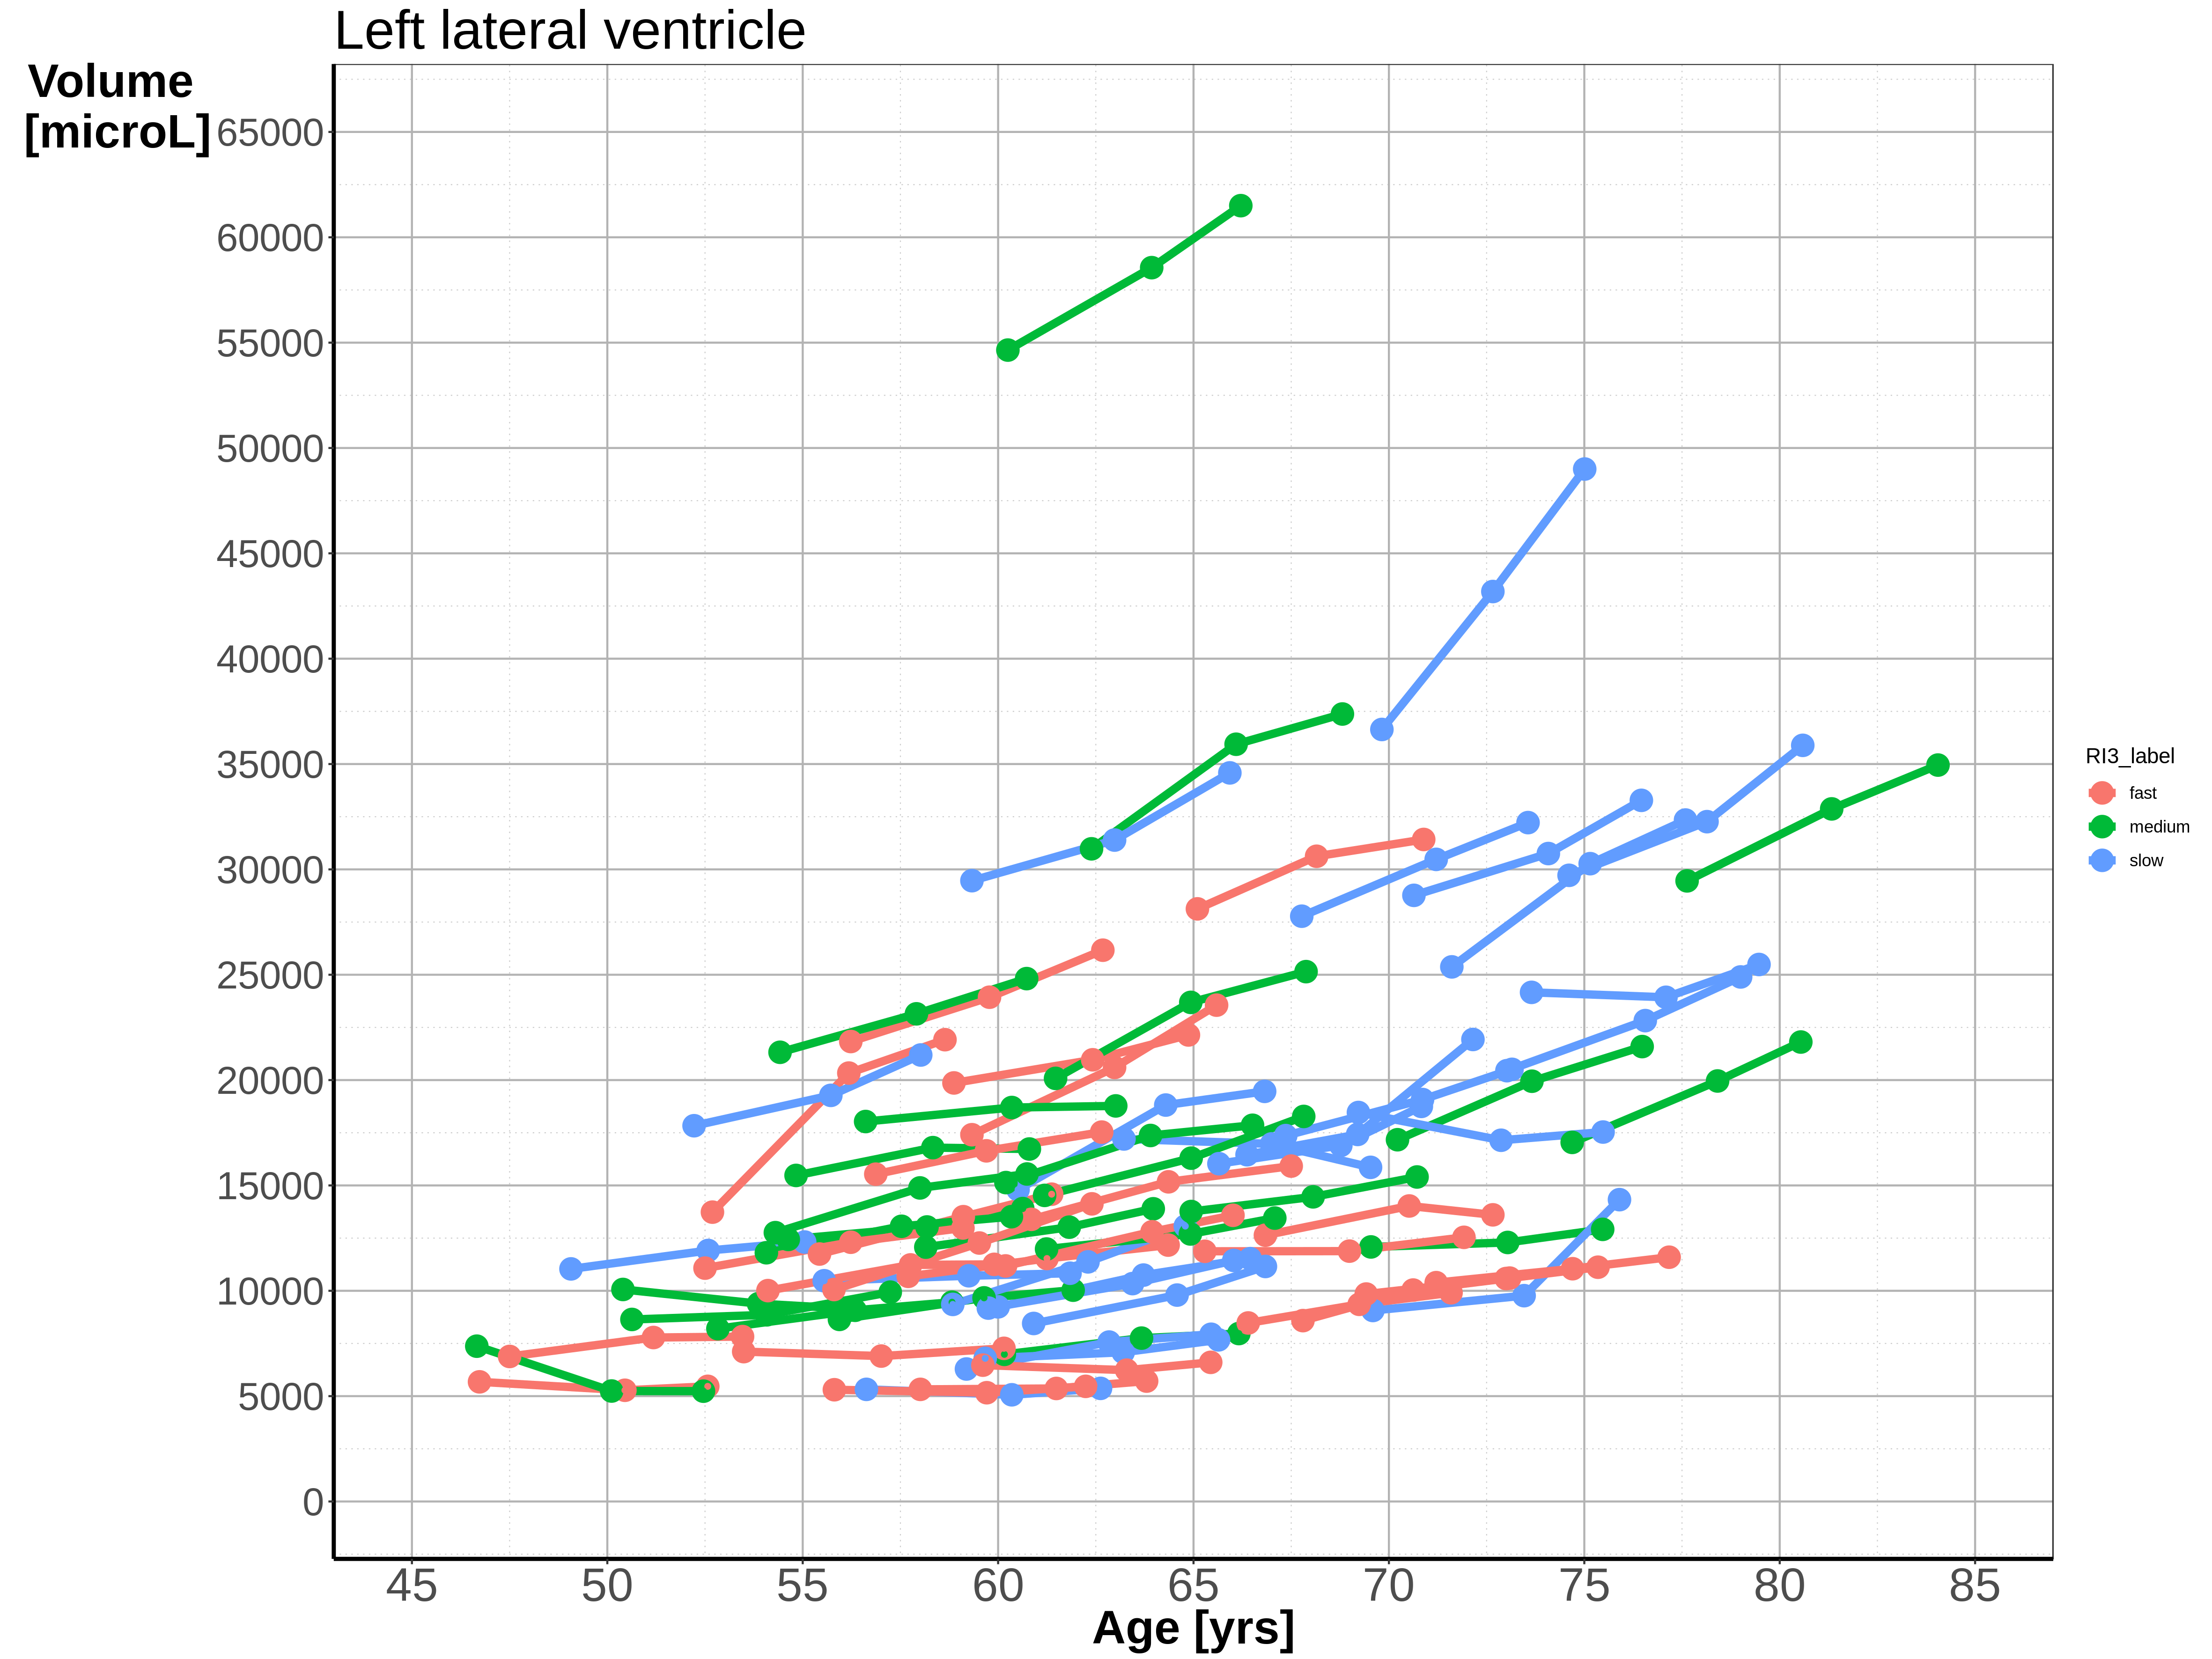

In [42]:
Image("../figures/03_lvv_ri_rpy2_left_ventricle_by_RI3_label.png", width=900)

In [43]:
dfR = pd_df_longR.copy()
dfR['id'] = dfR['subj']
dfR = dfR.drop(['Region', 'subj'], axis=1)
dfR.head(4)

Wave    Age   Volume  id
0     1  56.63   6855.2   1
1     2  60.35   6729.2   1
2     3  62.62   7233.2   1
3     1  49.07  10611.6   2

In [44]:
dfmriR = dfmri.copy()
# dfmriR['id'] = pd_df['id']
dfmriR['id'] = dfmri.index+1
#dfmriR['RI3_label'] = df_cat['RI3_label']
dfmriR['RI3_label'] = df_label['RI3_label']
dfmriR = dfmriR.drop(['Gender','Age3','b1iL','b1iR','VdevL','VdevR','RI3','RI3_jitter','RI3_cat'], axis=1)
dfmriR.head(4)

id RI3_label
0   1      slow
1   2      slow
2   3      slow
3   4      fast

In [45]:
di = pd.Series(dfmriR.RI3_label.values,index=dfmriR.id).to_dict()
di.items()

dict_items([(1, 'slow'), (2, 'slow'), (3, 'slow'), (4, 'fast'), (5, 'slow'), (6, 'slow'), (7, 'fast'), (8, 'medium'), (9, 'fast'), (10, 'medium'), (11, 'slow'), (12, 'medium'), (13, 'fast'), (14, 'medium'), (15, 'medium'), (16, 'medium'), (17, 'medium'), (18, 'slow'), (19, 'medium'), (20, 'medium'), (21, 'fast'), (22, 'fast'), (23, 'fast'), (24, 'fast'), (25, 'medium'), (26, 'slow'), (27, 'slow'), (28, 'fast'), (29, 'medium'), (30, 'medium'), (31, 'slow'), (32, 'slow'), (33, 'slow'), (34, 'slow'), (35, 'fast'), (36, 'fast'), (37, 'fast'), (38, 'medium'), (39, 'medium'), (40, 'medium'), (41, 'fast'), (42, 'fast'), (43, 'medium'), (44, 'medium'), (45, 'medium'), (46, 'fast'), (47, 'fast'), (48, 'slow'), (49, 'slow'), (50, 'slow'), (51, 'slow'), (52, 'slow'), (53, 'medium'), (54, 'fast'), (55, 'slow'), (56, 'slow'), (57, 'fast'), (58, 'slow'), (59, 'medium'), (60, 'fast'), (61, 'slow'), (62, 'medium'), (63, 'slow'), (64, 'slow'), (65, 'medium'), (66, 'fast'), (67, 'fast'), (68, 'fast'), (

In [46]:
dfR['Subject']=dfR['id']
dfR['id']=dfR['id'].astype('int32')
dfR['id'].replace(di, inplace=True)
dfR['RI3_label']=dfR['id'].astype('category')
dfR = dfR.drop(['id'], axis=1)
dfR.head()

Wave    Age   Volume  Subject RI3_label
0     1  56.63   6855.2        1      slow
1     2  60.35   6729.2        1      slow
2     3  62.62   7233.2        1      slow
3     1  49.07  10611.6        2      slow
4     2  52.58  11774.8        2      slow

In [47]:
# Save longitudinal Wave Age Volume Subject RI3_label for RIGHT hemsiphere as .csv
if eTIV_NORMALIZED:
    dfR.to_csv('../results/03_lvv_ri_RH_longitudinal_label_eTIV_norm.csv', header=True, index=False)
else:
    dfR.to_csv('../results/03_lvv_ri_RH_longitudinal_label.csv', header=True, index=False)

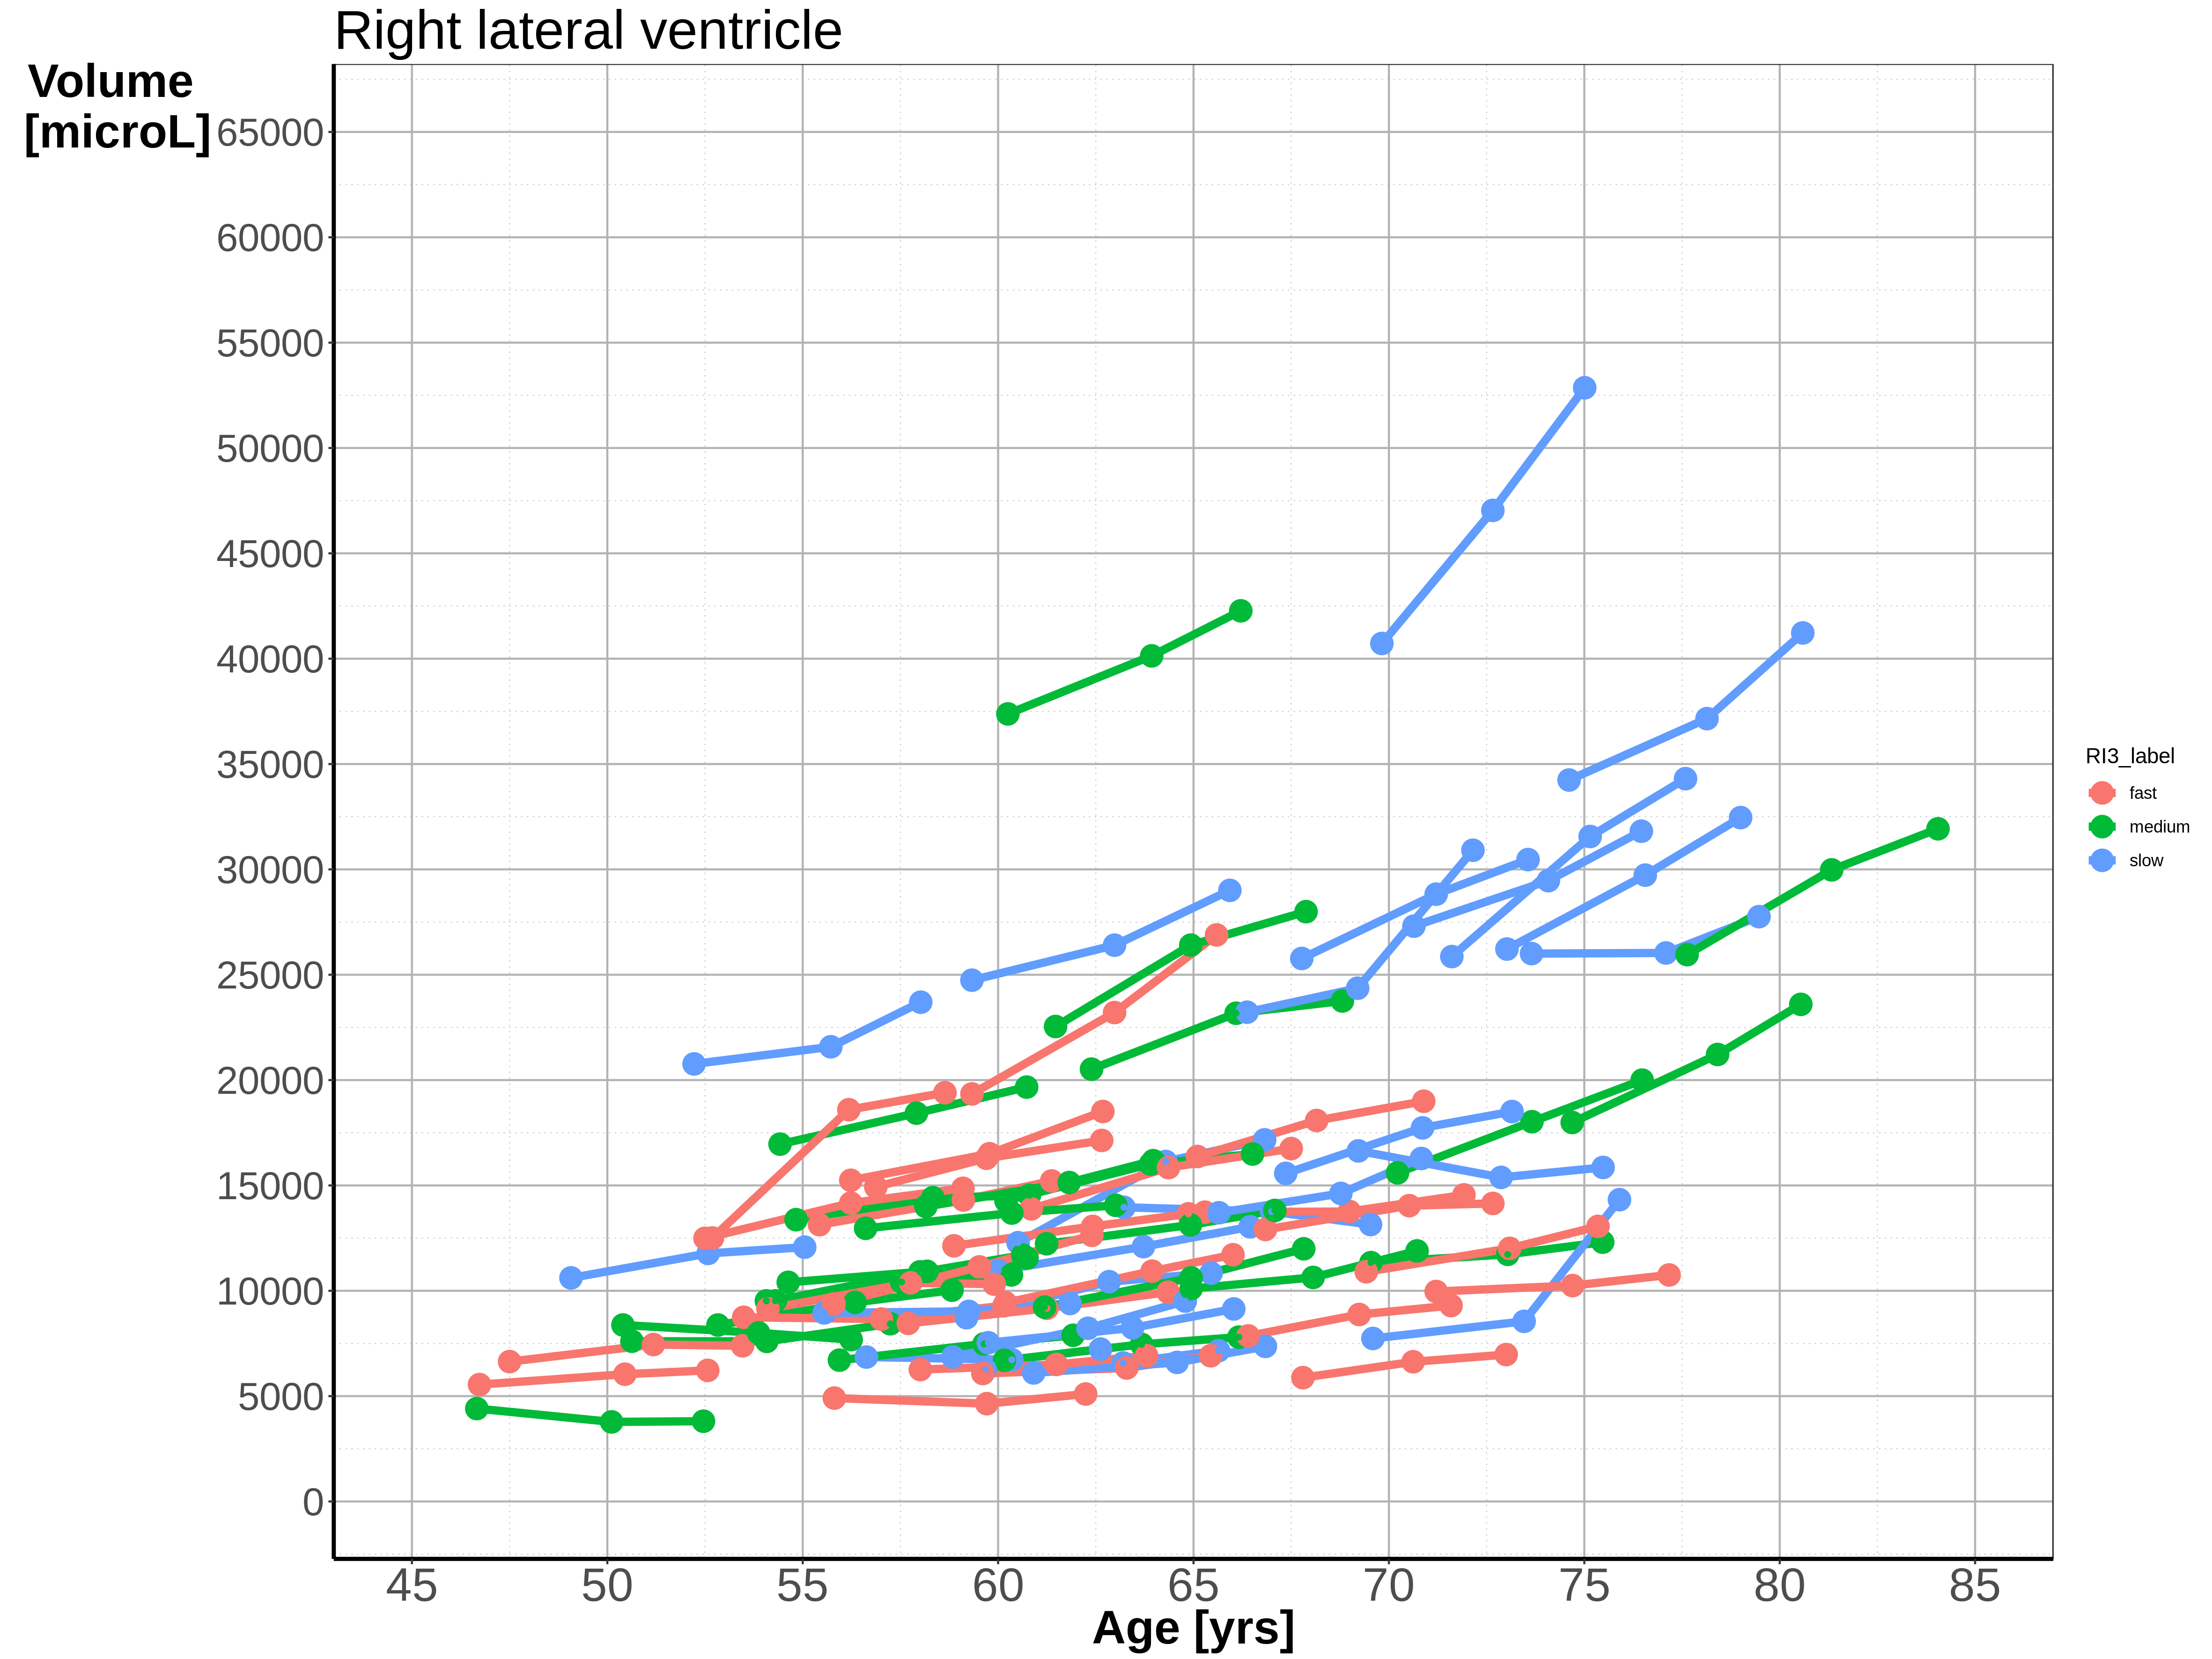

In [48]:
Image("../figures/03_lvv_ri_rpy2_right_ventricle_by_RI3_label.png", width=900)